In [165]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [166]:
import pandas as pd
import numpy as np

In [167]:
tls_data_path = '/content/gdrive/My Drive/My_Tls_analysis/tls_handshake.sampled.csv'
device_data_path = '/content/gdrive/My Drive/My_Tls_analysis/devices.b5038cbe.csv'

In [168]:
tls_df = pd.read_csv(tls_data_path)
device_df = pd.read_csv(device_data_path)

In [169]:
tls_df.head()

,cipher_suite_uses_grease,cipher_suites,client_ts,compression_methods,device_id,device_ip,device_port,extension_details,extension_types,extension_uses_grease,remote_ip,remote_port,sni,ts,type,user_key,version
0,NaN,49200+10+157+156+47+53+2570+49172+49171+49199+...,1.556562e+09,0,s8841916b09,10.6.6.9,41270,[<TLSExtension type=0xcaca length=0x0 |> <TL...,11+10+13+65281+21+23+18+16+51+45+35+43+0+27+5,True,54.192.50.14,443,c.amazon-adsystem.com,1556562393,client_hello,fa134d6a4a4f480316ea86e54ee34790,771
1,True,49200+10+157+156+47+53+49172+49171+49199+52393...,1.556563e+09,0,s8841916b09,10.6.6.9,38262,[<TLSExtension type=0x2a2a length=0x0 |> <TL...,11+10+13+65281+21+23+18+16+51+45+35+43+0+27+5,True,69.147.92.11,443,ct.yimg.com,1556562773,client_hello,fa134d6a4a4f480316ea86e54ee34790,771
2,True,49200+10+157+156+47+53+49172+49171+49199+52393...,1.556563e+09,0,s8841916b09,10.6.6.9,38751,[<TLSExtension type=0xaaaa length=0x0 |> <TL...,11+10+13+65281+21+23+18+16+51+45+35+43+0+27+5,True,35.190.90.202,443,heavyplayground.com,1556562795,client_hello,fa134d6a4a4f480316ea86e54ee34790,771
3,True,49200+10+157+156+47+53+49172+49171+49199+49195...,1.556563e+09,0,s12e8a92185,10.6.6.7,35685,[<TLSExtension type=0x2a2a length=0x0 |> <TL...,11+10+13+65281+23+18+16+35+0+27+5,True,172.217.12.193,443,yt3.ggpht.com,1556563029,client_hello,fa134d6a4a4f480316ea86e54ee34790,771
4,NaN,49200+151+49202+152+154+157+49201+159+158+4919...,1.556565e+09,0,sf2204e130c,10.6.6.19,34717,[<TLSExtension type=server_name length=0x24 |...,11+10+13+15+21+16+0+13172,NaN,52.215.124.26,443,lcprd1.samsungcloudsolution.net,1556564625,client_hello,fa134d6a4a4f480316ea86e54ee34790,771


In [170]:
device_df.head()

,device_id,device_ip,device_name,device_oui,device_type,device_vendor,dhcp_hostname,flow_last_update_ts,has_tracking_domains,is_inspected,netdisco_device_info_list,suspected_pc,ts,ua_list,user_key
0,s3b2dd7ac9e,10.6.6.6,NaN,00166c,NaN,NaN,NaN,1554758287,NaN,True,b64:eyJzc2RwX2Rlc2NyaXB0aW9uIjogImh0dHA6Ly8xMC...,NaN,1554758303,NaN,a97524e05ce24a13b68c2278e3b5c95a
1,sb728a609e3,10.6.6.8,NaN,a47733,NaN,NaN,NaN,1554758287,NaN,True,b64:eyJob3N0IjogIjEwLjYuNi44IiwgImhvc3RuYW1lIj...,NaN,1554758303,NaN,a97524e05ce24a13b68c2278e3b5c95a
2,sd3d4b5761d,10.6.6.15,NaN,4c11bf,NaN,NaN,NaN,1554758303,NaN,True,NaN,NaN,1554758303,NaN,a97524e05ce24a13b68c2278e3b5c95a
3,sb7a6452182,10.6.6.4,NaN,accf23,NaN,NaN,NaN,1554758282,NaN,True,NaN,NaN,1554758303,NaN,a97524e05ce24a13b68c2278e3b5c95a
4,s2142097cd9,10.6.6.5,NaN,600194,NaN,NaN,NaN,1554758282,NaN,True,NaN,NaN,1554758303,NaN,a97524e05ce24a13b68c2278e3b5c95a


In [171]:
interested_features_device_df = ['device_id','device_name','device_type']
interested_features_tls_df = ['cipher_suites','compression_methods','extension_types','version']

**Check if there is NaN value in the database, if so replace it with an empty string**

In [172]:
for feature in interested_features_tls_df:
  if tls_df[feature].isnull().values.any():
    print('{} column has empty values'.format(feature))
    print('There are {} empty values'.format(tls_df[feature].isnull().sum()))
  else:
    print('No empty value exists for column name: {}'.format(feature))

No empty value exists for column name: cipher_suites
No empty value exists for column name: compression_methods
extension_types column has empty values
There are 186 empty values
No empty value exists for column name: version


In [173]:
#Replace NaNs with '' for easier hash operation
tls_df.extension_types.fillna('',inplace=True)

In [174]:
#Change the type of cipher suite version from numeric to string
tls_df = tls_df.astype({'version':'str'})

In [175]:
#Md5 is used to derive a hash digest, which is the fingerprint
from hashlib import md5

In [176]:
#The identifying string, is composed of cipher suite, extension type, version, compression method
tls_df.cipher_suites[0]+','+tls_df.extension_types[0]+','+tls_df.version[0]+','+tls_df.compression_methods[0]


'49200+10+157+156+47+53+2570+49172+49171+49199+52393+52392+49195+49196+4866+4867+4865,11+10+13+65281+21+23+18+16+51+45+35+43+0+27+5,771,0'

**These four features will form an identifying string. Then, to iterate through this entire database, for each row add a hash digest, which is the fingerprint**

In [177]:
#Create a new column called fingerprints, which contains hash digests
tls_df['fingerprints'] = [md5(i.encode('utf-8')).hexdigest() for i in tls_df.cipher_suites+','+tls_df.extension_types+','+tls_df.version+','+tls_df.compression_methods]

**This is how the table looks like with fingerprints added**

In [178]:
tls_df

,cipher_suite_uses_grease,cipher_suites,client_ts,compression_methods,device_id,device_ip,device_port,extension_details,extension_types,extension_uses_grease,remote_ip,remote_port,sni,ts,type,user_key,version,fingerprints
0,NaN,49200+10+157+156+47+53+2570+49172+49171+49199+...,1.556562e+09,0,s8841916b09,10.6.6.9,41270,[<TLSExtension type=0xcaca length=0x0 |> <TL...,11+10+13+65281+21+23+18+16+51+45+35+43+0+27+5,True,54.192.50.14,443,c.amazon-adsystem.com,1556562393,client_hello,fa134d6a4a4f480316ea86e54ee34790,771,6d0a2bb01da5f942b07e0c92b56f965b
1,True,49200+10+157+156+47+53+49172+49171+49199+52393...,1.556563e+09,0,s8841916b09,10.6.6.9,38262,[<TLSExtension type=0x2a2a length=0x0 |> <TL...,11+10+13+65281+21+23+18+16+51+45+35+43+0+27+5,True,69.147.92.11,443,ct.yimg.com,1556562773,client_hello,fa134d6a4a4f480316ea86e54ee34790,771,b131ba5cd9be1d2846ac412d031134cf
2,True,49200+10+157+156+47+53+49172+49171+49199+52393...,1.556563e+09,0,s8841916b09,10.6.6.9,38751,[<TLSExtension type=0xaaaa length=0x0 |> <TL...,11+10+13+65281+21+23+18+16+51+45+35+43+0+27+5,True,35.190.90.202,443,heavyplayground.com,1556562795,client_hello,fa134d6a4a4f480316ea86e54ee34790,771,b131ba5cd9be1d2846ac412d031134cf
3,True,49200+10+157+156+47+53+49172+49171+49199+49195...,1.556563e+09,0,s12e8a92185,10.6.6.7,35685,[<TLSExtension type=0x2a2a length=0x0 |> <TL...,11+10+13+65281+23+18+16+35+0+27+5,True,172.217.12.193,443,yt3.ggpht.com,1556563029,client_hello,fa134d6a4a4f480316ea86e54ee34790,771,eac9600c183063254f3eee5717c1d424
4,NaN,49200+151+49202+152+154+157+49201+159+158+4919...,1.556565e+09,0,sf2204e130c,10.6.6.19,34717,[<TLSExtension type=server_name length=0x24 |...,11+10+13+15+21+16+0+13172,NaN,52.215.124.26,443,lcprd1.samsungcloudsolution.net,1556564625,client_hello,fa134d6a4a4f480316ea86e54ee34790,771,f85bd33675f86be13c116113cc0d12e1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23286,NaN,49200+157+156+47+53+49172+49171+49199+49195+49...,1.557395e+09,0,s2e4460494b,192.168.1.229,51316,[<TLSExtension type=server_name length=0xf |<...,11+10+13+16+35+0,NaN,3.209.6.216,443,k.pluto.tv,1557394783,client_hello,dP6WQKf4tfMPeAdw,771,1b424be162e4c5c0fae8236a5bc4d671
23287,NaN,49200+151+49202+152+154+157+49201+159+158+4919...,1.557395e+09,0,s81fe4d891c,192.168.1.115,35327,[<TLSExtension type=server_name length=0x12 |...,11+10+13+15+21+16+0+13172,NaN,37.187.124.179,443,box.easter.fr,1557394900,client_hello,iidYkxY3nFMmW55b,771,6a491b5fe30210cd7b8f361f76b26eac
23288,True,49200+10+157+156+47+53+49172+49171+49199+52393...,1.557395e+09,0,sc31bbbbf45,10.0.20.103,54592,[<TLSExtension type=0x6a6a length=0x0 |> <TL...,11+10+13+65281+23+18+16+51+45+35+43+0+27+5+41,True,172.217.14.110,443,clients4.google.com,1557394916,client_hello,rXEXrc5EtNtXCkai,771,14656070e02f3e6afc63ef19bf2027a0
23289,NaN,49200+49172+60+157+156+159+158+53+49171+49161+...,1.557395e+09,0,sc647c09ed8,172.16.10.33,59065,[<TLSExtension type=server_name length=0x18 |...,11+10+13+65281+23+35+0+5,NaN,50.16.7.138,443,acp-ss-ue1.adobe.io,1557394933,client_hello,W4A9yYhy4HHSmf93,771,aa74c80b3df6f8f7a79948381f001fc7


**Check how many fingerprints there are, and count how many are duplicated.**

**Duplicated fingerprint means some devices are using the same configuration in cipher suite, extension type, version, and compression method**

In [179]:
tls_df.fingerprints.value_counts()

0fa1b31c8f46e28372ff87c10e3a0d2f    2572
1a8307b54a5332ae1c81b6493ba9467e    2025
6a491b5fe30210cd7b8f361f76b26eac    1525
e44bef2e6d4d716719884fa4160d593b    1466
7e81d14240e1d5c9e7541baa20a2531e     948
                                    ... 
d40f2059f698f3a43f8df440fcad8b39       1
4dfea4f8cd4d6abe51b336b0eeb7e7fb       1
35c5dfac8c08c56c574e3f6d0be55a39       1
f61440a2413f8c9862156f8c4d0e2cb5       1
d7d7cbf6c78d59748200bc05db0ebc26       1
Name: fingerprints, Length: 616, dtype: int64

**This pie chart shows the top 20 fingerprints**

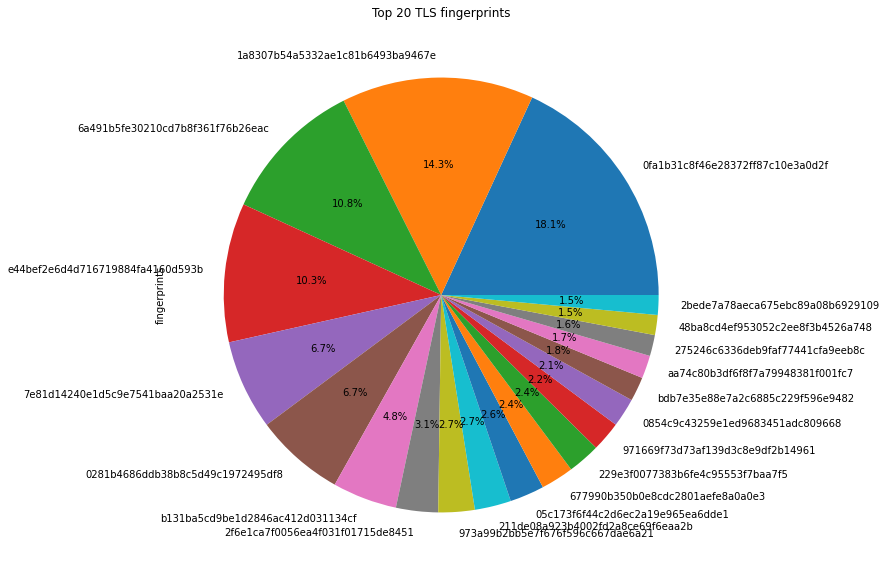

In [180]:
tls_df.fingerprints.value_counts().head(20).plot(kind='pie',figsize=(10,10),title='Top 20 TLS fingerprints',autopct='%1.1f%%')

In [181]:
print('These are the devices sharing a same fingerprint 0fa1b31c8f46e28372ff87c10e3a0d2f')
tls_df.loc[tls_df['fingerprints'] == '0fa1b31c8f46e28372ff87c10e3a0d2f']

These are the devices sharing a same fingerprint 0fa1b31c8f46e28372ff87c10e3a0d2f


,cipher_suite_uses_grease,cipher_suites,client_ts,compression_methods,device_id,device_ip,device_port,extension_details,extension_types,extension_uses_grease,remote_ip,remote_port,sni,ts,type,user_key,version,fingerprints
11,NaN,49200+157+156+60+61+49187+52392+52393+49188+47...,1.556608e+09,0,sf123b016f2,192.168.1.43,51065,[<TLSExtension type=renegotiation_info length...,11+10+13+65281+21+23+18+16+51+45+43+0+5+13172,NaN,46.5.165.200,443,miniserver.ed-kmh.de,1556608460,client_hello,4a48803ae9764110db88272374170a15,771,0fa1b31c8f46e28372ff87c10e3a0d2f
15,NaN,49200+157+156+60+61+49187+52392+52393+49188+47...,1.556612e+09,0,s73e8bbf731,192.168.178.54,56702,[<TLSExtension type=renegotiation_info length...,11+10+13+65281+21+23+18+16+51+45+43+0+5+13172,NaN,23.42.148.198,443,iphone-ld.apple.com,1556612129,client_hello,661bd624e8114e2b68d7fb8fe2acad9d,771,0fa1b31c8f46e28372ff87c10e3a0d2f
37,NaN,49200+157+156+60+61+49187+52392+52393+49188+47...,1.556613e+09,0,sb46d6ae193,192.168.1.64,49605,[<TLSExtension type=renegotiation_info length...,11+10+13+65281+21+23+18+16+51+45+43+0+5+13172,NaN,152.199.19.174,443,fo-static.omnitagjs.com,1556613140,client_hello,2c9238abfe3143dfa69ce838b618b600,771,0fa1b31c8f46e28372ff87c10e3a0d2f
39,NaN,49200+157+156+60+61+49187+52392+52393+49188+47...,1.556613e+09,0,sb46d6ae193,192.168.1.64,49908,[<TLSExtension type=renegotiation_info length...,11+10+13+65281+21+23+18+16+51+45+43+0+5+13172,NaN,23.42.150.222,443,z.moatads.com,1556613330,client_hello,2c9238abfe3143dfa69ce838b618b600,771,0fa1b31c8f46e28372ff87c10e3a0d2f
107,NaN,49200+157+156+60+61+49187+52392+52393+49188+47...,1.556615e+09,0,s73e8bbf731,192.168.178.54,56717,[<TLSExtension type=renegotiation_info length...,11+10+13+65281+21+23+18+16+51+45+43+0+5+13172,NaN,17.248.146.147,443,p28-caldav.icloud.com,1556614711,client_hello,661bd624e8114e2b68d7fb8fe2acad9d,771,0fa1b31c8f46e28372ff87c10e3a0d2f
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23139,NaN,49200+157+156+60+61+49187+52392+52393+49188+47...,1.557386e+09,0,s485e246d46,10.0.1.11,60261,[<TLSExtension type=renegotiation_info length...,11+10+13+65281+21+23+18+16+51+45+43+0+5+13172,NaN,13.35.125.39,443,forums.malwarebytes.com,1557386269,client_hello,8ae64d2bcd464cccfa5788a07daa66a7,771,0fa1b31c8f46e28372ff87c10e3a0d2f
23147,NaN,49200+157+156+60+61+49187+52392+52393+49188+47...,1.557387e+09,0,s75ab794b29,10.10.0.86,57575,[<TLSExtension type=renegotiation_info length...,11+10+13+65281+21+23+18+16+51+45+43+0+5+13172,NaN,23.5.130.217,443,itunes.apple.com,1557386617,client_hello,aFWXFd8ArCpgYjs3,771,0fa1b31c8f46e28372ff87c10e3a0d2f
23188,NaN,49200+157+156+60+61+49187+52392+52393+49188+47...,1.557389e+09,0,s485e246d46,10.0.1.11,60647,[<TLSExtension type=renegotiation_info length...,11+10+13+65281+21+23+18+16+51+45+43+0+5+13172,NaN,93.184.216.182,443,fast.fonts.net,1557388620,client_hello,8ae64d2bcd464cccfa5788a07daa66a7,771,0fa1b31c8f46e28372ff87c10e3a0d2f
23197,NaN,49200+157+156+60+61+49187+52392+52393+49188+47...,1.557389e+09,0,s5f888bdabb,192.168.1.101,58760,[<TLSExtension type=renegotiation_info length...,11+10+13+65281+21+23+18+16+51+45+43+0+5+13172,NaN,195.154.209.188,443,www.materneo.com,1557388983,client_hello,afL553SGB9yi2cM6,771,0fa1b31c8f46e28372ff87c10e3a0d2f


**These device ids represent devices that use the same TLS fingerprint 0fa1b31c8f46e28372ff87c10e3a0d2f**

In [182]:
tls_df.loc[tls_df['fingerprints'] == '0fa1b31c8f46e28372ff87c10e3a0d2f'].device_id

11       sf123b016f2
15       s73e8bbf731
37       sb46d6ae193
39       sb46d6ae193
107      s73e8bbf731
            ...     
23139    s485e246d46
23147    s75ab794b29
23188    s485e246d46
23197    s5f888bdabb
23280    se6232dfad5
Name: device_id, Length: 2572, dtype: object

In [183]:
print('The number of unique device ids is:')
print(tls_df.loc[tls_df['fingerprints'] == '0fa1b31c8f46e28372ff87c10e3a0d2f'].device_id.unique().size)
print('There are 274 unique devices using the same TLS configuration')

The number of unique device ids is:
274
There are 274 unique devices using the same TLS configuration


**The following table shows all the devices, that are using fingerprint 0fa1b31c8f46e28372ff87c10e3a0d2f**

**It is obvious that the majority of them are Apple devices**

In [184]:
#Use pd.dataframe.loc to grab rows that are in pd.series, where the series consist of the unique device ids having fingerprint 0fa1b31c8f46e28372ff87c10e3a0d2f
device_df.loc[device_df['device_id'].isin(tls_df.loc[tls_df['fingerprints'] == '0fa1b31c8f46e28372ff87c10e3a0d2f'].device_id.unique())]

,device_id,device_ip,device_name,device_oui,device_type,device_vendor,dhcp_hostname,flow_last_update_ts,has_tracking_domains,is_inspected,netdisco_device_info_list,suspected_pc,ts,ua_list,user_key
8740,s1c82dc92cc,192.168.1.20,NaN,d81c79,NaN,NaN,iPhone,1557065233,NaN,True,NaN,NaN,1557065284,Mozilla/5.0 (iPhone; CPU iPhone OS 12_2 like M...,83872ce78b4f4fe69622e5d9a1a80aa5
13942,s4e83825413,192.168.86.38,NaN,9cf48e,NaN,NaN,Mels-iPhone,1555681664,NaN,True,NaN,True,1557405431,server-bag [iPhone OS 12.3 16F5148a iPhone8 1]...,6e0cd2b055ca4347257cf33b9ed49c0e
13956,sa6334000ed,192.168.86.24,Iphone X,4098ad,Smartphone,Apple,Calvins-iPhone,1555681781,NaN,True,NaN,True,1557494239,iNetLite/1928 CFNetwork/978.0.7 Darwin/18.6.0+...,6e0cd2b055ca4347257cf33b9ed49c0e
14564,se693e3b0df,192.168.0.3,Google Wifi,703acb,Wifi Router,Google,NaN,1557381804,NaN,True,NaN,NaN,1557494455,iOS/12.3 (16F5129d) dataaccessd/1.0+Java+serve...,6e0cd2b055ca4347257cf33b9ed49c0e
25925,sd402461046,192.168.10.18,NaN,f8e94e,NaN,NaN,Bossk-XsM,1556762421,NaN,True,NaN,NaN,1556762454,com.apple.trustd/2.0+1.1.1.1.worker/1904262200...,e2d11a69d12348ca4a049386dde47f25
27232,s84cb73f40b,192.168.10.37,NaN,c0a600,NaN,NaN,NaN,1556762393,NaN,True,NaN,NaN,1556762454,Mozilla/5.0 (iPhone; CPU iPhone OS 12_2 like M...,e2d11a69d12348ca4a049386dde47f25
29404,s89793fd80e,192.168.2.59,Apple iPhone XS Max,f099b6,Apple iPhone,apple,Kens-iPhone,1556900101,NaN,True,NaN,NaN,1556907287,Mozilla/5.0 (iPhone; CPU OS 12_2 like Mac OS X...,1382977e9e314628f96e4835edd313da
29942,s8dc482c00b,192.168.2.60,apple iphone,d81c79,cellphone,apple,Tarahs-iPhone,1556907287,NaN,True,NaN,NaN,1556907287,iOS/12.2 (16E227) dataaccessd/1.0+com.apple.tr...,1382977e9e314628f96e4835edd313da
30316,s4bde0bfb4b,192.168.1.83,NaN,e83617,NaN,NaN,AppleWanJuergen,1557056424,NaN,True,NaN,NaN,1557058106,CaptiveNetworkSupport-355.200.27 wispr+server-...,2c9238abfe3143dfa69ce838b618b600
31182,s27649defce,192.168.100.183,NaN,5462e2,NaN,NaN,NaN,1557126456,NaN,True,NaN,NaN,1557126505,NaN,3c5df2dfdb7f4a47875e67098b15dda2


**There are this much unique fingerprints in the sampled TLS traffic data**

In [185]:
tls_df.fingerprints.value_counts().keys()

Index(['0fa1b31c8f46e28372ff87c10e3a0d2f', '1a8307b54a5332ae1c81b6493ba9467e',
       '6a491b5fe30210cd7b8f361f76b26eac', 'e44bef2e6d4d716719884fa4160d593b',
       '7e81d14240e1d5c9e7541baa20a2531e', '0281b4686ddb38b8c5d49c1972495df8',
       'b131ba5cd9be1d2846ac412d031134cf', '2f6e1ca7f0056ea4f031f01715de8451',
       '973a99b2bb5e7f676f596c667dae6a21', '211de08a923b4002fd2a8ce69f6eaa2b',
       ...
       '1bb547b45822d85c67e7d8f901e90ae4', '8bc4adf1344f82943ca23069a25e310d',
       '7c36905689025026021e81fefd6e523b', '691b92870304c8819ae88e353dea6ab6',
       '56f64a5cc2d097703feaa5bd3e56fa02', 'd40f2059f698f3a43f8df440fcad8b39',
       '4dfea4f8cd4d6abe51b336b0eeb7e7fb', '35c5dfac8c08c56c574e3f6d0be55a39',
       'f61440a2413f8c9862156f8c4d0e2cb5', 'd7d7cbf6c78d59748200bc05db0ebc26'],
      dtype='object', length=616)

**The following extracts data from device database, and put them in associating fingerprints**

In [186]:
from collections import OrderedDict #Want to keep the order, the top fingerprints mean a large number of device produce that fingerprint
my_dict = OrderedDict()
for keys in tls_df.fingerprints.value_counts().keys():#Iterate through all the fingerprint, for each fingerprint, find unique device ids that produce such fingerprint
  l = []
  unique_device_ids = tls_df.loc[tls_df['fingerprints'] == keys].device_id.unique()
  #The inner loop extracts device information from the device database
  for item in zip(device_df.loc[device_df['device_id'].isin(unique_device_ids)].device_name,
                  device_df.loc[device_df['device_id'].isin(unique_device_ids)].device_type,
                  device_df.loc[device_df['device_id'].isin(unique_device_ids)].device_vendor,
                  device_df.loc[device_df['device_id'].isin(unique_device_ids)].dhcp_hostname,):
    l.append(item)
    
  my_dict[keys]= l  #Save data in a dictionary {key:value} where key = fingerprint = hash(TLS configuration), value = [device information]


**The following displays each fingerprint, and devices**

In [187]:
for key, value in my_dict.items():
  print('The following devices are all having the same TLS fingerprint: {}'.format(key))
  if value:
    for item in value:
      device_name, device_type, device_vendor, dhcp_hostname = item
      print('device name: {}, device type: {}, device vendor: {}, device dhcp hostname: {}'.format(device_name, device_type, device_vendor, dhcp_hostname))
  print('--'*30)

The following devices are all having the same TLS fingerprint: 0fa1b31c8f46e28372ff87c10e3a0d2f
device name: nan, device type: nan, device vendor: nan, device dhcp hostname: iPhone
device name: nan, device type: nan, device vendor: nan, device dhcp hostname: Mels-iPhone
device name: Iphone X, device type: Smartphone, device vendor: Apple, device dhcp hostname: Calvins-iPhone
device name: Google Wifi, device type: Wifi Router, device vendor: Google, device dhcp hostname: nan
device name: nan, device type: nan, device vendor: nan, device dhcp hostname: Bossk-XsM
device name: nan, device type: nan, device vendor: nan, device dhcp hostname: nan
device name: Apple iPhone XS Max, device type: Apple iPhone, device vendor: apple, device dhcp hostname: Kens-iPhone
device name: apple iphone, device type: cellphone, device vendor: apple, device dhcp hostname: Tarahs-iPhone
device name: nan, device type: nan, device vendor: nan, device dhcp hostname: AppleWanJuergen
device name: nan, device type: 

**Creates a new dataframe, and write it to a CSV**

In [188]:
new_df = pd.DataFrame.from_dict(my_dict,orient='index')

In [189]:
new_df = new_df.transpose()

In [190]:
new_df

,0fa1b31c8f46e28372ff87c10e3a0d2f,1a8307b54a5332ae1c81b6493ba9467e,6a491b5fe30210cd7b8f361f76b26eac,e44bef2e6d4d716719884fa4160d593b,7e81d14240e1d5c9e7541baa20a2531e,0281b4686ddb38b8c5d49c1972495df8,b131ba5cd9be1d2846ac412d031134cf,2f6e1ca7f0056ea4f031f01715de8451,973a99b2bb5e7f676f596c667dae6a21,211de08a923b4002fd2a8ce69f6eaa2b,05c173f6f44c2d6ec2a19e965ea6dde1,677990b350b0e8cdc2801aefe8a0a0e3,229e3f0077383b6fe4c95553f7baa7f5,971669f73d73af139d3c8e9df2b14961,0854c9c43259e1ed9683451adc809668,bdb7e35e88e7a2c6885c229f596e9482,aa74c80b3df6f8f7a79948381f001fc7,275246c6336deb9faf77441cfa9eeb8c,48ba8cd4ef953052c2ee8f3b4526a748,2bede7a78aeca675ebc89a08b6929109,f4116f0ceef0fd9c4b82eb2df0953eeb,8d8aa4697785ae86acafc462870d11f9,d04cd16d994ecf7cf5396af6092c172c,59745d42b4eab43e7851fbc556e00a0d,1b424be162e4c5c0fae8236a5bc4d671,65f31af2a36921f19b9222fb6c3eea80,131a648a63b326964d9ac4a25725f74c,81281921dd8e060a05e7ee6a7fc3f63a,c352d8a92e98d0ddecc9d67510cd0297,dcb927d34ebc437885bd7e4c5a44ad4f,14656070e02f3e6afc63ef19bf2027a0,7e3c57db9ebc0f2757b219646e4575d0,4f6acd06390d09a27d4ff20075e8cc85,2d54ba8b1ba1f777f73a58102533de9a,e48b6b1a355c1b9a648c36cdcfbc1087,d92027b404bc5e2470a622e608b0c90f,01a4468dd70a93329022e2155c308cb9,9a7f3e0e338fd5efe08137510aa61366,3eff836d544dee6c04e2df1afb91cb8d,63c0ccaeda5825514194e1e3c03f10c6,...,02a0f7a2cb6ced69a1a468cb253b229f,e19ae3901f91a91a07bbefc27a33c9a8,262768b0779b072f2b7c7d5894cede89,bb4e4daa19edcff8aadd63a4e88ac66f,fbea3cdc4e8f3dbcaee0a8837a79febe,e4e86d41f954a71592c866a9308f5d9f,b8670e7276b126416c03fd2f68fb718a,d3ce1b528a4af96bc529ad9276e0cd02,ec6573fa0e7b2a148d2a6ba817d86ef0,e35ea31961f37330608e555a519541da,47caa78449ac56b11a2fb48563154ccd,1b40896b4b742d0115f3338e8c36104f,1a11dc4e7261398e6d99266b715a3b4b,ff79ca799e2cb8cb1285f80be7c2d28e,ccc451d0517f9fd7deafce1381dafd9f,3d70fbe46b49064b63f5e0584e72edb4,80db66ab6ec961102aaca087b298a91f,c9c1557d1c18a4b63c5245ba44d3725f,f772d33431bf67dc8a573e4dda52a227,4338a490d8c6c87833efb5a4aba6b803,34f9ade1436d91bb030afdcc2100dee1,abfd6200912814d3960a503e4aa9fca8,ebc44446d4a77705d0add4d52cbd4874,27d1dcad7683f957a3072c0f87354961,e477953ba6dd2db9276d609dade863a3,e5b7efed00299c95ebacc0b7e80e888c,cae461d0b802426f326de1558cddd490,a02fffbd84976d1ae1148a25ccea6d34,85c62712a6ee9ac3ee8e32ff2526cfef,1dc2c5e93a92ac77eb22ab4ce15e50e1,1bb547b45822d85c67e7d8f901e90ae4,8bc4adf1344f82943ca23069a25e310d,7c36905689025026021e81fefd6e523b,691b92870304c8819ae88e353dea6ab6,56f64a5cc2d097703feaa5bd3e56fa02,d40f2059f698f3a43f8df440fcad8b39,4dfea4f8cd4d6abe51b336b0eeb7e7fb,35c5dfac8c08c56c574e3f6d0be55a39,f61440a2413f8c9862156f8c4d0e2cb5,d7d7cbf6c78d59748200bc05db0ebc26
0,"(nan, nan, nan, iPhone)","(Carmela MacBook, Laptop, Apple, WCL-DI-MBP-MDP)","(nan, nan, nan, DS211)","(nan, nan, nan, nan)","(nan, nan, nan, nan)","(nan, nan, nan, nan)","(Moto G, smartphone, Motorola, nan)","(Google Home, Automation Hub, Google, Google-H...","(nan, nan, nan, nan)",None,"(Den Shield TV, Android TV, NVIDIA, nan)","(nan, nan, nan, nan)","(nan, nan, nan, Mels-iPhone)","(nan, nan, nan, Mels-iPhone)",None,"(Home Assistant, Automation Software, Hass.io,...","(nan, nan, nan, nan)","(nan, nan, nan, nan)",None,"(nan, nan, nan, AGSI-Veriton-4)","(xbox, Gaming Console, Microsoft, XboxOne)","(PC, Windows PC, Lenovo, AllIsNumber_PC)","(Mac mini, dator, Apple, nan)","(nan, nan, nan, nan)","(Amazon Show, smart speaker, Amazon, amazon-0b...","(nan, nan, nan, Patio)","(Apple iPhone XS Max, Apple iPhone, apple, Ken...","(nan, nan, nan, AGSI-Veriton-4)","(xbox, Gaming Console, Microsoft, XboxOne)","(nan, nan, nan, nan)","(nan, nan, nan, heron-nb)","(Den Shield TV, Android TV, NVIDIA, nan)","(Den Shield TV, Android TV, NVIDIA, nan)","(Carmela MacBook, Laptop, Apple, WCL-DI-MBP-MDP)","(nan, nan, nan, os-ws-10)","(nan, nan, nan, jarvis-nsa-gov)","(One+ 6 - E, Smartphone, OnePlus, OnePlus6)","(xbox, Gaming Console, Microsoft, XboxOne)","(nan, nan, nan, nan)","(nan, nan, nan, nan)",...,None,"(August Connect, WiFi Door Lock, August, augus

In [191]:
new_df.to_csv('/content/gdrive/My Drive/My_Tls_analysis/tls_result.csv')

**The above is a strict fingerprint, four features are used to produce a fingerprint**

**The following will be a less strict analysis, where I will choose 2 features out of 4 to produce the fingerprint**

**4 choose 2 = 6, so there are 6 combinations. Order is not important so no permutation**


















In [192]:
from itertools import combinations

comb = combinations(interested_features_tls_df,2)
#for i in comb:
#  print(i)

**For each combination, create a dictionary to hold the device data. Because the fingerprint is created in a less strict way, there is some difference**

In [193]:
for feature in comb:
  print(feature)
  tls_df['fingerprints'] = [md5(i.encode('utf-8')).hexdigest() for i in tls_df[feature[0]]+','+tls_df[feature[1]]]
  my_dict = OrderedDict()
  for keys in tls_df.fingerprints.value_counts().keys():#Iterate through all the fingerprint, for each fingerprint, find unique device ids that produce such fingerprint
    l = []
    unique_device_ids = tls_df.loc[tls_df['fingerprints'] == keys].device_id.unique()
    #The inner loop extracts device information from the device database
    for item in zip(device_df.loc[device_df['device_id'].isin(unique_device_ids)].device_name,
                  device_df.loc[device_df['device_id'].isin(unique_device_ids)].device_type,
                  device_df.loc[device_df['device_id'].isin(unique_device_ids)].device_vendor,
                  device_df.loc[device_df['device_id'].isin(unique_device_ids)].dhcp_hostname,):
      l.append(item)
    
    my_dict[keys]= l
  print(my_dict)

('cipher_suites', 'compression_methods')
OrderedDict([('ad0e2fcfe3374544e729bb49ae8fb020', [(nan, nan, nan, 'iPhone'), (nan, nan, nan, 'Mels-iPhone'), ('Iphone X', 'Smartphone', 'Apple', 'Calvins-iPhone'), ('Sky Router', 'Router', 'Sky', nan), ('Google Wifi', 'Wifi Router', 'Google', nan), (nan, nan, nan, 'Bossk-XsM'), (nan, nan, nan, nan), ('Apple iPhone XS Max', 'Apple iPhone', 'apple', 'Kens-iPhone'), ('apple iphone', 'cellphone', 'apple', 'Tarahs-iPhone'), (nan, nan, nan, 'AppleWanJuergen'), (nan, nan, nan, nan), (nan, nan, nan, nan), (nan, nan, nan, 'Toms-MBP'), (nan, nan, nan, nan), (nan, nan, nan, 'MartinaiPhoneXR'), (nan, nan, nan, nan), (nan, nan, nan, 'iPhone-Markus'), ('iphone xr', 'iphone', 'Apple', 'iPhone'), ('Xiaomi WiFi', 'WiFi extender', 'Xiaomi', nan), (nan, nan, nan, 'Antons-iPhone'), ('Apple TV', 'Streaming Video', 'Apple', nan), (nan, nan, nan, 'Lee-mbpR15'), ('no idea', 'no idea', 'no idea', nan), (nan, nan, nan, nan), (nan, nan, nan, nan), ('iPhone XS', 'Phone', 

In [195]:
comb = combinations(interested_features_tls_df,2)
for feature in comb:
  print(feature)
  tls_df['fingerprints'] = [md5(i.encode('utf-8')).hexdigest() for i in tls_df[feature[0]]+','+tls_df[feature[1]]]
  my_dict = OrderedDict()
  for keys in tls_df.fingerprints.value_counts().keys():#Iterate through all the fingerprint, for each fingerprint, find unique device ids that produce such fingerprint
    l = []
    unique_device_ids = tls_df.loc[tls_df['fingerprints'] == keys].device_id.unique()
    #The inner loop extracts device information from the device database
    for item in zip(device_df.loc[device_df['device_id'].isin(unique_device_ids)].device_name,
                  device_df.loc[device_df['device_id'].isin(unique_device_ids)].device_type,
                  device_df.loc[device_df['device_id'].isin(unique_device_ids)].device_vendor,
                  device_df.loc[device_df['device_id'].isin(unique_device_ids)].dhcp_hostname,):
      l.append(item)
    
    my_dict[keys]= l
  for key, value in my_dict.items():
    print('The following devices are all having the same TLS fingerprint: {}'.format(key))
    if value:
      for item in value:
        device_name, device_type, device_vendor, dhcp_hostname = item
        print('device name: {}, device type: {}, device vendor: {}, device dhcp hostname: {}'.format(device_name, device_type, device_vendor, dhcp_hostname))
    print('--'*30)
  print('#'*60)

Streaming output truncated to the last 5000 lines.
device name: Den Shield TV, device type: Android TV, device vendor: NVIDIA, device dhcp hostname: nan
device name: Moto G, device type: smartphone, device vendor: Motorola, device dhcp hostname: nan
device name: nan, device type: nan, device vendor: nan, device dhcp hostname: AGSI-Veriton-4
device name: XBR-65X850D, device type: TV, device vendor: SONY, device dhcp hostname: nan
device name: TV1, device type: 4K TV, device vendor: SONY, device dhcp hostname: android-9a8d1579aad2914d
device name: nan, device type: nan, device vendor: nan, device dhcp hostname: Terra-03
device name: nan, device type: nan, device vendor: nan, device dhcp hostname: Terra-04
device name: nan, device type: nan, device vendor: nan, device dhcp hostname: Terra-01
device name: nan, device type: nan, device vendor: nan, device dhcp hostname: Terra-08
device name: nan, device type: nan, device vendor: nan, device dhcp hostname: Terra-06
device name: nan, device t

**Analysis of the above output**


For instance, when the fingerprint is composed of compression method and version, the output looks like this:

############################################################
('compression_methods', 'version')

The following devices are all having the same TLS fingerprint: 
9e58df9f282094a8f2c4c8ba4a7b19f6

device name: nan, device type: nan, device vendor: nan, device dhcp hostname: nan

device name: nan, device type: nan, device vendor: nan, device dhcp hostname: nan

device name: nan, device type: nan, device vendor: nan, device dhcp hostname: RasPlex

device name: nan, device type: nan, device vendor: nan, device dhcp hostname: nan

device name: Google Home, device type: Automation Hub, device vendor: Google, 

device dhcp hostname: Google-Home

device name: nan, device type: nan, device vendor: nan, device dhcp hostname: nan

device name: nan, device type: nan, device vendor: nan, device dhcp hostname: iPhone

device name: nan, device type: nan, device vendor: nan, device dhcp hostname: nan

device name: PS4, device type: Gaming Console, device vendor: Sony, device dhcp hostname: nan

device name: Echo Dot, device type: Voice Assistant, device vendor: Amazon, 

device dhcp hostname: amazon-530e37e23

device name: Smart TV, device type: Television, device vendor: Samsung, device dhcp hostname: localhost

device name: Smart TV, device type: Television, device vendor: Samsung, device dhcp hostname: localhost

device name: Echo Dot, device type: Voice Assistant, device vendor: Amazon, device dhcp hostname: amazon-7ab4471e7

device name: nan, device type: nan, device vendor: nan, device dhcp hostname: Alexis-Surface-Pro



**There is Google Home, which is an automation hub. It produces the same TLS fingerprints as PS4  and  Samsung TV**

**This is due to the  fact that at this instance, the TLS fingerprint is composed  of  compression method and version only(0,771). This less strict fingerprint is not very accurate. Because one can't make a confident claim that 2 applications are using the same underlying software, because their compression method and version are the same**
